In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from lorenz_data.data_generator import data_generator_sde
from lorenz_data.data_generator import euler_sde
from lorenz_data.data_generator import euler_sde_net
from lorenz_data.data_generator import euler
import sys
import os

In [2]:
sys.path.append("../src")
sys.path.append("../src/onetlib")

In [3]:
import onsagernet as onet

## Stochastic lorenz system

The Lorenz 63 system is a determinisic ODE system:
$$
\begin{aligned}
\frac{dX}{d\tau} & = -\sigma X +\sigma Y\\
\frac{dY}{d\tau} &= -XZ +rX -Y\\
\frac{dZ}{d\tau} &= XY-bZ\\\
\end{aligned}$$

Here we consider the generalization of lorenz 63 system:
$$
\begin{aligned}
dX & = (-\sigma X +\sigma Y)d\tau +A_{11} d W_1 + A_{12}d W_2 + A_{13} d W_3\\
dY &= (-XZ +rX -Y)d\tau + A_{21} d W_1 + A_{22}d W_2 + A_{23} d W_3\\
dZ &= (XY-bZ)d\tau+ A_{31} d W_1 + A_{32}d W_2 + A_{33} d W_3\\
\end{aligned}$$

$\sigma,r, b,A_{ij},i= 1,2,3,j = 1,2,3$ are parameters and $W_i, i =1,2,3$ are Brownian motion which satisfies $W_i(t)-W_i(s) \sim \mathcal{N}(0,t-s),t>s$.

We choose $\sigma = 10, b = 8/3, r = 16$.
$$\begin{pmatrix}
A_{11}&A_{12}&A_{13}\\
A_{21}&A_{22}&A_{23}\\
A_{31}&A_{32}&A_{33}\\
\end{pmatrix} = \begin{pmatrix}
0.05X+0.5&0.1X&-0.02XZ\\
0&-0.1Y&-0.8\\
1&0.02XY&0.05Z\\
\end{pmatrix}$$

### Data generation

We want to generalize $N$ snapshots $D = \{(x^{(k)},y^{(k)},h^{(k)}\ )\}_{k=1}^{N}$  ,where  $x^{(k)}$ are points scattered in the state space $\mathbb{R}^3$of the lorenz system.The $N$ datapoints $x^{(k)}$ are used as the input variables of our neural network. $y^{(k)}$ results from the evolution the lorenz system under a small time-step $h^{(k)}>0$, starting at $x^{(k)}$. $N$ datapoints $y^{(k)}$ are used as the output variables accordingly. $x^{(k)}$ are sampled from a distribution $f_0(x)$, and $h^{(k)}$ are sampled from distribution $f_h$. Note that the step size $h^{(k)}$ may not be a constant.

We assume $f_0$ is uniformly distributed over $[-5,5]^3$, and $h$ equals to the constant $0.005$.


In [4]:
sigma = 10.
b = 8.0/3.0
r = 16.


# only consider time-homogeneous sde systems
# Any non-timehomogeneous sde system can be transformed 
# into a time-homogeneous system by adding another variable   
def drift(u):
    return np.array([-sigma*u[0]+sigma*u[1],
                    -u[0]*u[2]+r*u[0]-u[1],
                    u[0]*u[1]-b*u[2]])


def diffusitivity(u):
    return np.array([[0.05*u[0]+0.5,0.1*u[0],-0.02*u[0]*u[2]],[0.,-0.1*u[1],-0.8],[1.,0.02*u[0]*u[1],0.05*u[2]]])

In [5]:
tf.random.set_seed(1)
n_samples = 1000*100
n_dim = 3
delta_t = 0.005

X_data = tf.random.uniform(shape = (n_samples,n_dim),minval = -5, maxval = 5)
h = tf.ones((n_samples,1))*0.005

Data_generator = data_generator_sde(drift = drift, diffusitivity = diffusitivity)
Y_data = Data_generator.euler_sde(X_data,h)

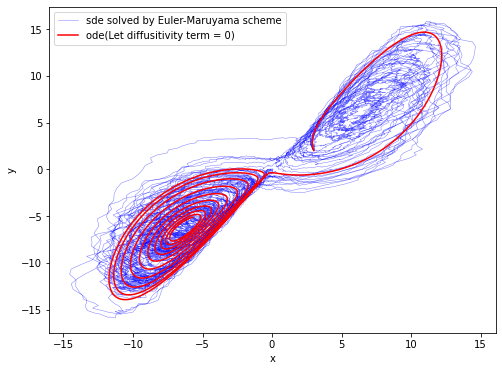

In [6]:
fig = plt.figure(figsize = (8,6))
axes = fig.add_subplot(1,1,1)
u0 = np.array([3,2,2])
for i in range(10):
    t,u = euler_sde(drift,diffusitivity,u0 = u0,delta_t = delta_t,N = 2000,n_dim = 3)
    axes.plot(u[:,0],u[:,1],'b',alpha = 0.5,linewidth = 0.5)
t,u = euler_sde(drift,diffusitivity,u0 = u0,delta_t = delta_t,N = 2000,n_dim = 3)
axes.plot(u[:,0],u[:,1],'b',linewidth = 0.5,alpha = 0.5,label = 'sde solved by Euler-Maruyama scheme')
t,u = euler(drift,u0 = u0, t_span = (0,10),N = 100000,n_dim = 3)
axes.plot(u[:,0],u[:,1],'r',label = 'ode(Let diffusitivity term = 0)')
axes.set_xlabel('x')
axes.set_ylabel('y')
axes.legend()
plt.show()

In [7]:
np.savez('lorenz_data/Lorenz_sde.npz',X_data = X_data, Y_data  = Y_data)

In [8]:
# Load data
path = 'lorenz_data/Lorenz_sde.npz'
with np.load(path) as data:
    X_data = data['X_data']
    Y_data = data['Y_data']

In [9]:
X_train,X_test,Y_train,Y_test = train_test_split(
    np.array(X_data),np.array(Y_data),test_size=0.3,shuffle = True
)   

## Build model

In [10]:
beta = 0.1
alpha = 0.01
n_features = 3
pot_layer_size = [16,16,4,4]
dc_layer_sizes = [16,16,4]
fc_layer_sizes = [16,16,4,4]
diffu_layer_sizes = [36,36,36,36,9,9,9,9]

In [11]:
# build Onsager net 
def build_onsager_net():
    potential_net = onet.FCPotentialNet(beta = beta,
                                       layer_sizes = pot_layer_size,
                                       n_pot = n_features)
    dissconv_net = onet.FCDissConsNet(n_dim = n_features,
                                     layer_sizes = dc_layer_sizes)
    forcing_net = onet.FCForcingNet(n_dim = n_features,layer_sizes = fc_layer_sizes)
    onsager_net = onet.OnsagerNet(n_dim = n_features,
                                  potential_net = potential_net,
                                  dissconv_net = dissconv_net,
                                  forcing_net = forcing_net,
                                  alpha = alpha)
    diffusitivitynet = onet.DiffusitivityNet(n_dim = n_features,layer_sizes = diffu_layer_sizes)
    
    inputs = tf.keras.Input((n_features,))
    outputs = tf.concat([inputs,onsager_net(inputs),diffusitivitynet(inputs)],1)
    
    onsager_rhs = tf.keras.Model(inputs,outputs,name = 'onsager_rhs')
    return onsager_rhs

In [12]:
model = onet.SDEOnsagerNet(n_features = n_features,delta_t = delta_t, OnsagerNet = build_onsager_net())
model.build(input_shape = (None,n_features))
model.summary()

Model: "sde_onsager_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 onsager_rhs (Functional)    (None, 15)                6160      
                                                                 
Total params: 6,160
Trainable params: 6,160
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01), loss = onet.CustomEulerLoss(epsilon = 1e-4,n_features = n_features,delta_t = delta_t))

Let's have a look at the predicted drift $f(x)$ and diffusitivity $\sigma(x)$ before traing the neural network. Since the stochastic lorenz system's space belong to $\mathbb{R}^3$, its difficult to draw pictures of $f$ and $\sigma$ directly. Instead, we choose 1 trajectory in the phase space:$(x,x^2-1,-3x+0.5),x\in [-1,2]$.

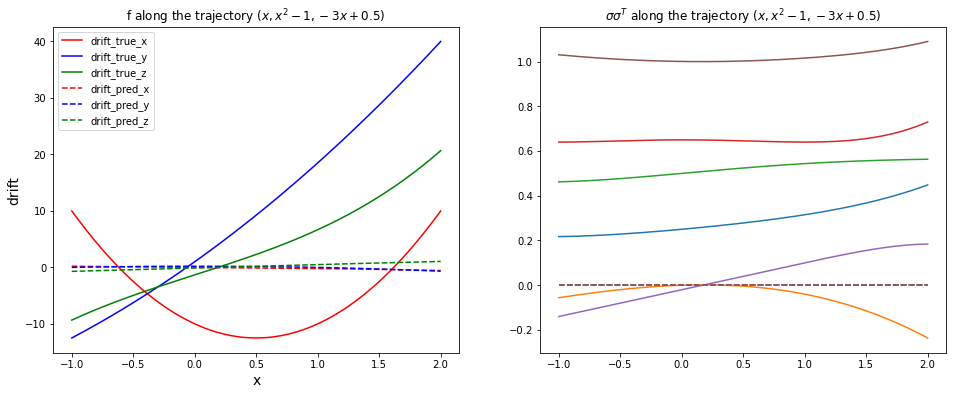

In [14]:
fig = plt.figure(figsize = (16,6))
axes = fig.add_subplot(1,2,1)

x = np.linspace(-1,2,200).reshape(-1,1)
xyz = np.concatenate([x,x**2-1,-3*x+0.5],1)

drift_true = np.apply_along_axis(drift,1,xyz)
axes.plot(x,drift_true[:,0],'r',label = 'drift_true_x')
axes.plot(x,drift_true[:,1],'b',label = 'drift_true_y')
axes.plot(x,drift_true[:,2],'g',label = 'drift_true_z')

pred = model.call(xyz)
drift_pred = pred[:,n_features:2*n_features]
axes.plot(x,drift_pred[:,0],'r--',label = 'drift_pred_x')
axes.plot(x,drift_pred[:,1],'b--',label = 'drift_pred_y')
axes.plot(x,drift_pred[:,2],'g--',label = 'drift_pred_z')

axes.set_xlabel('x',fontsize = 14)
axes.set_ylabel('drift',fontsize = 14)
axes.set_title('f along the trajectory $(x,x^2-1,-3x+0.5)$')
axes.legend()


axes = fig.add_subplot(1,2,2)
diffusitivity_true = np.apply_along_axis(diffusitivity,1,xyz)
diffu_diffuT_true = tf.einsum('ijk,ilk->ijl',diffusitivity_true,diffusitivity_true)
diffu_diffuT_true = tf.reshape(diffu_diffuT_true,shape = (-1,n_features * n_features))

diffusitivity_pred = pred[:,2*n_features:]
diffusitivity_pred = tf.reshape(diffusitivity_pred,shape = (-1,n_features,n_features))
diffu_diffuT_pred = tf.einsum('ijk,ilk->ijl',diffusitivity_pred,diffusitivity_pred)
diffu_diffuT_pred = tf.reshape(diffu_diffuT_pred,shape = (-1,n_features * n_features))

index = np.array([0,1,2,4,5,8])
for i in index:
    p = axes.plot(x,diffu_diffuT_true[:,i],label = 'true_{}'.format(i))
    axes.plot(x,diffu_diffuT_pred[:,i],'--',color = p[0].get_color(),label = 'pred_{}'.format(i))
axes.set_title('$\sigma\sigma^T$ along the trajectory $(x,x^2-1,-3x+0.5)$')

plt.show()

In the right figure, we plot the true and predicted $\sigma \sigma^T$ along the trajectory $(x,x^2-5,-3x+0.5)$. Since $\sigma \sigma^T$ is a symetric matrix, we only plot the upper triangular part of $\sigma \sigma^T$.

We can observe from the picture that the true drift f and the predicted drift before training are very different.  The true $\sigma \sigma^T$  and predicted $\sigma \sigma^T$  are totally different too.

Now let us train the model.

In [15]:
model.evaluate(X_train,Y_train)

2188/2188 [==============================] - 5s 2ms/step - loss: 11017236.0000


11017236.0

In [16]:
# set learning rate
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',factor = 0.4, patience = 2, min_lr = 1e-7)
history = model.fit(x = X_train,
                    y = Y_train,
                    validation_data = (X_test,Y_test),
                    batch_size= 64,
                    epochs = 100,
                    callbacks = lr)

Epoch 1/100
1094/1094 [==============================] - 7s 4ms/step - loss: 10416.8848 - val_loss: -9.0405 - lr: 0.0100
Epoch 2/100
1094/1094 [==============================] - 4s 4ms/step - loss: -9.1728 - val_loss: -9.1929 - lr: 0.0100
Epoch 3/100
1094/1094 [==============================] - 4s 3ms/step - loss: -9.4450 - val_loss: -9.5876 - lr: 0.0100
Epoch 4/100
1094/1094 [==============================] - 4s 4ms/step - loss: -9.5926 - val_loss: -9.8264 - lr: 0.0100
Epoch 5/100
1094/1094 [==============================] - 4s 4ms/step - loss: -10.1959 - val_loss: -10.5991 - lr: 0.0100
Epoch 6/100
1094/1094 [==============================] - 4s 3ms/step - loss: -10.5843 - val_loss: -10.4869 - lr: 0.0100
Epoch 7/100
1094/1094 [==============================] - 4s 3ms/step - loss: -10.6319 - val_loss: -10.4866 - lr: 0.0100
Epoch 8/100
1094/1094 [==============================] - 4s 4ms/step - loss: -10.8736 - val_loss: -10.8337 - lr: 0.0040
Epoch 9/100
1094/1094 [======================

In [17]:
model.evaluate(X_test,Y_test)

938/938 [==============================] - 2s 2ms/step - loss: -11.2248


-11.224830627441406

Let us have a look at the predicted $f$ and $\sigma$ after training the model. We choose 1 trajectory in the phase space:$(x,x^2-1,-3x+0.5),x\in [-1,2]$ again and plot the true and predicted $f$ along the trajectory.

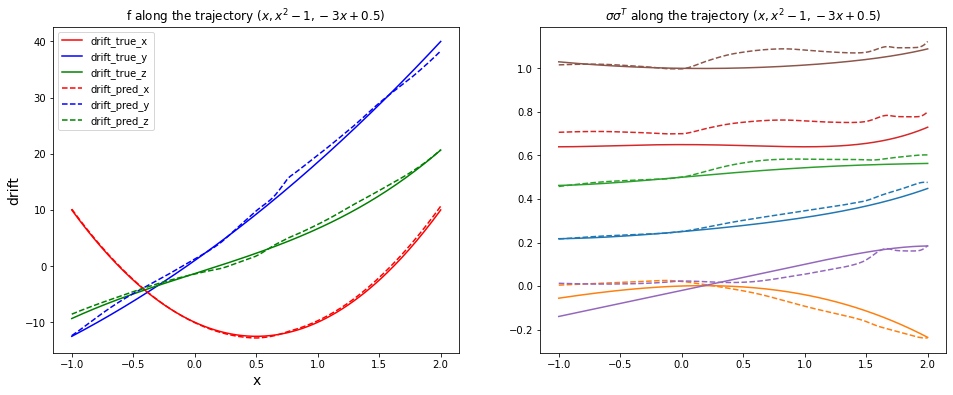

In [18]:
fig = plt.figure(figsize = (16,6))
axes = fig.add_subplot(1,2,1)

x = np.linspace(-1,2,200).reshape(-1,1)
xyz = np.concatenate([x,x**2-1,-3*x+0.5],1)

drift_true = np.apply_along_axis(drift,1,xyz)
axes.plot(x,drift_true[:,0],'r',label = 'drift_true_x')
axes.plot(x,drift_true[:,1],'b',label = 'drift_true_y')
axes.plot(x,drift_true[:,2],'g',label = 'drift_true_z')

pred = model.call(xyz)
drift_pred = pred[:,n_features:2*n_features]
axes.plot(x,drift_pred[:,0],'r--',label = 'drift_pred_x')
axes.plot(x,drift_pred[:,1],'b--',label = 'drift_pred_y')
axes.plot(x,drift_pred[:,2],'g--',label = 'drift_pred_z')

axes.set_xlabel('x',fontsize = 14)
axes.set_ylabel('drift',fontsize = 14)
axes.set_title('f along the trajectory $(x,x^2-1,-3x+0.5)$')
axes.legend()


axes = fig.add_subplot(1,2,2)
diffusitivity_true = np.apply_along_axis(diffusitivity,1,xyz)
diffu_diffuT_true = tf.einsum('ijk,ilk->ijl',diffusitivity_true,diffusitivity_true)
diffu_diffuT_true = tf.reshape(diffu_diffuT_true,shape = (-1,n_features * n_features))

diffusitivity_pred = pred[:,2*n_features:]
diffusitivity_pred = tf.reshape(diffusitivity_pred,shape = (-1,n_features,n_features))
diffu_diffuT_pred = tf.einsum('ijk,ilk->ijl',diffusitivity_pred,diffusitivity_pred)
diffu_diffuT_pred = tf.reshape(diffu_diffuT_pred,shape = (-1,n_features * n_features))

index = np.array([0,1,2,4,5,8])
for i in index:
    p = axes.plot(x,diffu_diffuT_true[:,i],label = 'true_{}'.format(i))
    axes.plot(x,diffu_diffuT_pred[:,i],'--',color = p[0].get_color(),label = 'pred_{}'.format(i))
axes.set_title('$\sigma\sigma^T$ along the trajectory $(x,x^2-1,-3x+0.5)$')

plt.show()

The predicted $f$ and the true $f$ fits rather well.
The predicted $\sigma \sigma^T$ and the ture one also fits well.